# Dependencies and Libraries

In [1]:
!pip install shap
!pip install lime
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import warnings
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

# Dataset

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')
# %cd /content/drive/MyDrive/"Colab Notebooks"/ADL/HW4/Q1
%cd /content/drive/MyDrive/HW4/Q1
output_dir = './models/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1wbVsFr4i8gZ3oyjgtNgYZZCPrrS704e6/HW4/Q1


In [4]:
# !wget  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
# !unzip cola_public_1.1.zip

In [5]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
sentences = df.sentence.values
labels = torch.tensor(df.label.values)

# Tokenizing

In [6]:
from transformers import DistilBertTokenizer
import torch

def Tokenize(sentences,tokenizer):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens = True,
                            max_length = 64,
                            pad_to_max_length = True,
                            truncation=True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                    )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids,attention_masks

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

input_ids,attention_masks = Tokenize(sentences,tokenizer)
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Dataloader

In [7]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,random_state=2018, test_size=0.1)

In [8]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Classification Model

In [10]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False
)

model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [11]:
from transformers import get_linear_schedule_with_warmup, AdamW

epochs = 10
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Training

In [ ]:
training_stats = []
best_val_acc=0
for epoch_i in range(0, epochs):
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        loss, logits = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels).to_tuple()
        total_train_loss += loss.item()
        loss.backward()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_train_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)    
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, attention_mask=b_input_mask,labels=b_labels).to_tuple()
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print('Epoch {:} / {:}: train_loss: {:.3f}, train_acc: {:.2f}, val_loss: {:.3f}, val_acc: {:.2f}'.format(epoch_i + 1, epochs,avg_train_loss,avg_train_accuracy,avg_val_loss,avg_val_accuracy))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'train_loss': avg_train_loss,
            'train_acc': avg_train_accuracy,
            'val_loss': avg_val_loss,
            'val_acc': avg_val_accuracy
        }
    )
    if avg_val_accuracy>best_val_acc:
        print('validation accuracy improved from {:.2f}% to {:.2f}%, model saved'.format(best_val_acc*100,avg_val_accuracy*100))
        best_val_acc = avg_val_accuracy
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)

model = DistilBertForSequenceClassification.from_pretrained(output_dir)
model = model.to(device)

Epoch 1 / 10: train_loss: 0.535, train_acc: 0.73, val_loss: 0.527, val_acc: 0.77
validation accuracy improved from 0.00% to 77.01%, model saved
Epoch 2 / 10: train_loss: 0.373, train_acc: 0.84, val_loss: 0.493, val_acc: 0.79
validation accuracy improved from 77.01% to 79.21%, model saved
Epoch 3 / 10: train_loss: 0.258, train_acc: 0.90, val_loss: 0.553, val_acc: 0.79
Epoch 4 / 10: train_loss: 0.180, train_acc: 0.93, val_loss: 0.636, val_acc: 0.80
validation accuracy improved from 79.21% to 79.98%, model saved
Epoch 5 / 10: train_loss: 0.139, train_acc: 0.95, val_loss: 0.637, val_acc: 0.81
validation accuracy improved from 79.98% to 80.59%, model saved
Epoch 6 / 10: train_loss: 0.098, train_acc: 0.97, val_loss: 0.821, val_acc: 0.80
Epoch 7 / 10: train_loss: 0.083, train_acc: 0.98, val_loss: 0.892, val_acc: 0.79
Epoch 8 / 10: train_loss: 0.064, train_acc: 0.98, val_loss: 0.950, val_acc: 0.80
Epoch 9 / 10: train_loss: 0.054, train_acc: 0.99, val_loss: 0.966, val_acc: 0.80
Epoch 10 / 10: t

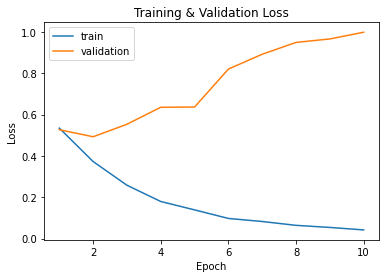

In [ ]:
import matplotlib.pyplot as plt

df_stats = pd.DataFrame(data=training_stats).set_index('epoch')
plt.plot(df_stats['train_loss'], label="train")
plt.plot(df_stats['val_loss'], label="validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test

In [12]:
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
sentences = df.sentence.values
labels = torch.tensor(df.label.values)

In [13]:
model = DistilBertForSequenceClassification.from_pretrained(output_dir)
model = model.to(device)

input_ids,attention_masks = Tokenize(sentences,tokenizer)
batch_size = 32  
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [15]:
from sklearn.metrics import matthews_corrcoef

model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids,attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
acc = (flat_true_labels==flat_predictions).sum()/len(flat_predictions)
print('Test Accuracy: {0:.2f}%'.format(acc*100))
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: {0:.2f}'.format(mcc))

Test Accuracy: 78.10%
Total MCC: 0.46


# Lime

In [14]:
import torch.nn.functional as F

def predictor(sentences):
    input_ids,attention_masks = Tokenize(sentences,tokenizer)
    # input_ids = torch.cat(input_ids, dim=0)
    # attention_masks = torch.cat(attention_masks, dim=0)
    prediction_data = TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=len(input_ids))
    
    model.eval()
    predictions = []
    for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch
        outputs = model(b_input_ids,attention_mask=b_input_mask)
        logits = outputs[0]
        logits = F.softmax(logits, dim=1)
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    return predictions[0]

In [ ]:
from lime.lime_text import LimeTextExplainer

label_names = [0, 1]
explainer = LimeTextExplainer(class_names=label_names)
for sent in sentences[40:50]:
    exp = explainer.explain_instance(sent, predictor)
    exp.show_in_notebook(text=True)

Output hidden; open in https://colab.research.google.com to view.

# SHAP

In [55]:
import shap

explainer = shap.Explainer(predictor, tokenizer, output_names=[0,1])
shap_values = explainer(sentences[40:50])
shap.text_plot(shap_values)

Partition explainer: 11it [00:11,  5.65s/it]
